## Activity Recognition Analysis Project
### Shanshan Lin

The data retrieved from repository was in .zip format. For this project, extracting all csv files and combining into one main input dataset. 

Please make sure the data folder, 'AReM', was stored in the same directory as this script.

### Data Extractions and Processing

In [1]:
## Environment set-up
import pandas as pd 
import numpy as np
import os
import re
from functools import reduce
import warnings
warnings.filterwarnings("ignore")

# get current directory this script is installed in
current_fp = os.getcwd()
main_dir = os.path.join(current_fp, 'ARem')
filenames = os.listdir(main_dir) # list of everything in data folder
read_list = []
for file in filenames:
    # file contains some pdfs and read-me files. skipping those.
    if not file.endswith(".pdf") and not file.startswith('.'): 
        read_list.append(file) # list of all files to be read

Each 'activity' folder has multiple csvs, one for each measured subject. This below loop iterates through each folder and combine all the measured subject within each activity folders into one. 

The output is a list with multiple dataframes, one for each activity.

In [2]:
df_all = [] # container to store dataframes
# loop through individual activities 
for activity_type in read_list:
    #print(activity_type)
    activity_files = os.listdir(main_dir + '/' + activity_type)

    activity_list = []
    # loop through each file 
    for file in activity_files:
        #print(file)
        df = pd.read_csv(os.path.join(main_dir, activity_type, file), sep='delimiter', header=None, engine = 'python')
        df = df[0].str.split(',| ', expand=True)
        df = df.mask(df.eq('None'))
        df.iloc[0:5] = df.iloc[0:5].shift(periods=-2, axis="columns")
        df = df.dropna(axis=0, thresh=3) # drop rows with all NAs
        df = df.dropna(axis=1, thresh=400) # drop columns with all NAs
        new_header = df.iloc[0] #grab the first row for the header
        df = df[1:] #take the data less the header row
        df.columns = new_header
        df = df.add_suffix('_'+activity_type)
        df = df.rename(columns={df.columns[0]: 'time'})
        df['subject_id'] = re.findall("\d+", file) * len(df)
        #print(df)
        # append into list container
        activity_list.append(df)
    
    activity_df = pd.concat(activity_list) # combining all individuals together
    activity_df['subject_id'] = pd.to_numeric(activity_df['subject_id'])
    activity_df['time'] = pd.to_numeric(activity_df['time'])
    activity_df = activity_df.sort_values(['subject_id', 'time'])
    activity_df = activity_df.reset_index(drop = True)
    activity_df.columns.names = [None]
    df_all.append(activity_df)

The below loop iterates through each element in the list of dataframe, adding certain attributes to each and combining into one main input dataset.

In [3]:
activity_all = pd.DataFrame() # main dataframe
for i in df_all:
    if len(activity_all) == 0:
        activity_all = i
    else:
        activity_all = pd.merge(activity_all, i, on = ['time', 'subject_id'], how = 'outer')

var_cols = list(activity_all.columns[activity_all.columns.str.startswith('var_')])
var_df = activity_all[['time'] + var_cols + ['subject_id']]
var_df['num_type'] = 'variance'
var_df.columns = var_df.columns.str.replace(r'var_', '')

mean_cols = list(activity_all.columns[activity_all.columns.str.startswith('avg_')])
mean_df = activity_all[['time'] + mean_cols + ['subject_id']]
mean_df['num_type'] = 'mean'
mean_df.columns = mean_df.columns.str.replace(r'avg_', '')

activity_all = pd.concat([mean_df, var_df]).reset_index(drop = True)
activity_all.iloc[:,:-1] = activity_all.iloc[:,:-1].apply(pd.to_numeric, errors='coerce', downcast='float')
activity_all

,time,rss12_bending1,rss13_bending1,rss23_bending1,rss12_bending2,rss13_bending2,rss23_bending2,rss12_cycling,rss13_cycling,rss23_cycling,...,rss13_sitting,rss23_sitting,rss12_standing,rss13_standing,rss23_standing,rss12_walking,rss13_walking,rss23_walking,subject_id,num_type
0,0.0,39.25,22.75,33.75,23.75,24.00,24.67,32.00,17.50,22.50,...,19.200001,15.50,46.50,11.50,20.33,35.00,16.50,14.00,1.0,mean
1,250.0,39.25,23.00,33.00,22.67,24.00,24.67,40.50,14.00,21.75,...,19.330000,11.00,46.50,12.00,20.25,28.50,17.50,12.25,1.0,mean
2,500.0,39.25,23.25,33.00,21.33,24.00,24.75,40.50,11.33,18.25,...,17.500000,12.50,46.50,12.00,20.50,35.50,15.75,17.75,1.0,mean
3,750.0,39.50,23.00,33.00,21.00,24.00,25.25,34.50,20.67,19.00,...,17.000000,13.33,46.50,12.75,19.50,29.75,16.25,20.75,1.0,mean
4,1000.0,39.50,24.00,33.00,23.00,23.75,24.75,34.50,21.25,18.25,...,17.500000,12.00,46.50,13.25,18.75,27.00,16.75,24.75,1.0,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14395,118750.0,NaN,NaN,NaN,NaN,NaN,NaN,2.55,2.17,4.74,...,1.300000,0.82,0.43,0.43,0.83,6.18,3.56,4.19,15.0,variance
14396,119000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.41,1.25,...,0.000000,1.25,0.00,0.80,0.83,6.02,2.05,1.58,15.0,variance
14397,119250.0,NaN,NaN,NaN,NaN,NaN,NaN,1.73,0.43,0.87,...,0.470000,1.41,0.00,0.00,0.50,3.35,5.12,2.95,15.0,variance
14398,119500.0,NaN,NaN,NaN,NaN,NaN,NaN,3.74,4.18,1.41,...,0.500000,0.47,0.50,0.43,0.50,2.77,3.24,0.43,15.0,variance


Summary statistics of the main input data:

In [4]:
activity_all.describe()

,time,rss12_bending1,rss13_bending1,rss23_bending1,rss12_bending2,rss13_bending2,rss23_bending2,rss12_cycling,rss13_cycling,rss23_cycling,...,rss12_sitting,rss13_sitting,rss23_sitting,rss12_standing,rss13_standing,rss23_standing,rss12_walking,rss13_walking,rss23_walking,subject_id
count,14400.000000,6720.000000,6720.000000,6720.000000,5760.000000,5760.000000,5760.000000,14400.000000,14400.000000,14400.000000,...,14398.000000,14398.000000,14398.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000
mean,59875.000000,21.561043,9.976115,15.377186,14.931482,8.040796,9.855190,19.717737,9.692945,10.217959,...,21.074957,7.807379,8.502000,22.128176,7.695013,7.308747,19.385534,9.299085,9.684335,8.000000
std,34642.144531,21.176102,9.752878,15.380126,15.034754,8.667468,9.829397,17.297165,7.273597,7.653540,...,20.884003,7.983947,8.404433,21.811153,7.636405,6.986910,15.524427,6.535880,6.818944,4.320644
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,29937.500000,0.470000,0.500000,0.470000,0.430000,0.470000,0.830000,2.170000,2.770000,2.740000,...,0.470000,0.470000,0.820000,0.470000,0.470000,0.830000,3.940000,3.000000,3.110000,4.000000
50%,59875.000000,18.000000,5.135000,6.630000,8.830000,2.860000,4.495000,16.335000,8.010000,8.360000,...,18.844999,3.110000,3.640000,17.175000,3.400000,3.500000,15.435000,8.060000,8.005000,8.000000
75%,89812.500000,42.750000,19.500000,31.500000,29.000000,15.750000,18.500000,36.250000,16.330000,17.500000,...,42.330002,15.250000,17.250000,44.750000,15.250000,14.000000,35.000000,15.500000,16.000000,12.000000
max,119750.000000,48.000000,30.000000,38.669998,51.000000,35.000000,40.330002,45.000000,28.500000,27.000000,...,50.750000,27.250000,30.750000,48.250000,24.000000,24.000000,51.250000,25.250000,26.000000,15.000000


### Exploratory Data Analysis

In the first section of the EDA, the missing values will be imputed as the average value of the column. The study did not specify whether 'subject1' across different activities is the same person, however, this data is treating it as such for the purpose of the project. It is unclear why there are 15 subjects for certain activities but only 6-7 for some others, therefore, instead of dropping the missing values, they will be imputed using the average number of their according column.

In [5]:
# separate mean and variance 
mean_activity = activity_all[activity_all['num_type'] == 'mean'].reset_index(drop=True)
var_activity = activity_all[activity_all['num_type'] == 'variance'].reset_index(drop=True)

Preview of the datasets for mean and variance:

In [6]:
mean_activity

,time,rss12_bending1,rss13_bending1,rss23_bending1,rss12_bending2,rss13_bending2,rss23_bending2,rss12_cycling,rss13_cycling,rss23_cycling,...,rss13_sitting,rss23_sitting,rss12_standing,rss13_standing,rss23_standing,rss12_walking,rss13_walking,rss23_walking,subject_id,num_type
0,0.0,39.25,22.75,33.75,23.75,24.00,24.67,32.00,17.50,22.50,...,19.200001,15.50,46.50,11.50,20.33,35.00,16.50,14.00,1.0,mean
1,250.0,39.25,23.00,33.00,22.67,24.00,24.67,40.50,14.00,21.75,...,19.330000,11.00,46.50,12.00,20.25,28.50,17.50,12.25,1.0,mean
2,500.0,39.25,23.25,33.00,21.33,24.00,24.75,40.50,11.33,18.25,...,17.500000,12.50,46.50,12.00,20.50,35.50,15.75,17.75,1.0,mean
3,750.0,39.50,23.00,33.00,21.00,24.00,25.25,34.50,20.67,19.00,...,17.000000,13.33,46.50,12.75,19.50,29.75,16.25,20.75,1.0,mean
4,1000.0,39.50,24.00,33.00,23.00,23.75,24.75,34.50,21.25,18.25,...,17.500000,12.00,46.50,13.25,18.75,27.00,16.75,24.75,1.0,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,118750.0,NaN,NaN,NaN,NaN,NaN,NaN,38.00,18.25,20.00,...,17.250000,11.00,45.25,12.25,13.75,34.50,9.00,12.67,15.0,mean
7196,119000.0,NaN,NaN,NaN,NaN,NaN,NaN,36.00,19.00,13.67,...,18.000000,10.67,45.00,12.60,14.25,25.75,13.75,16.00,15.0,mean
7197,119250.0,NaN,NaN,NaN,NaN,NaN,NaN,37.00,17.75,22.50,...,18.670000,11.00,45.00,12.00,14.50,31.50,10.25,16.25,15.0,mean
7198,119500.0,NaN,NaN,NaN,NaN,NaN,NaN,37.00,19.00,22.00,...,18.500000,12.33,45.50,12.25,14.50,33.75,14.00,13.75,15.0,mean


In [7]:
var_activity

,time,rss12_bending1,rss13_bending1,rss23_bending1,rss12_bending2,rss13_bending2,rss23_bending2,rss12_cycling,rss13_cycling,rss23_cycling,...,rss13_sitting,rss23_sitting,rss12_standing,rss13_standing,rss23_standing,rss12_walking,rss13_walking,rss23_walking,subject_id,num_type
0,0.0,0.43,0.43,1.3,0.43,0.00,0.47,4.85,3.35,3.20,...,0.98,2.06,0.50,0.50,0.94,3.67,3.77,1.63,1.0,variance
1,250.0,0.43,0.00,0.0,0.94,0.00,0.94,1.12,2.24,1.30,...,0.94,0.82,0.50,0.00,0.43,3.35,3.77,3.90,1.0,variance
2,500.0,0.43,0.43,0.0,0.47,0.00,0.83,2.60,4.50,5.31,...,0.50,0.50,0.50,0.00,0.50,2.87,2.86,5.07,1.0,variance
3,750.0,0.50,0.71,0.0,0.00,0.00,1.09,1.50,2.87,2.83,...,1.41,0.94,0.50,0.43,0.50,12.19,2.17,2.59,1.0,variance
4,1000.0,0.50,0.00,0.0,0.71,0.43,0.83,1.50,3.27,4.38,...,0.87,0.82,0.50,0.43,0.43,2.12,0.83,1.64,1.0,variance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,118750.0,NaN,NaN,NaN,NaN,NaN,NaN,2.55,2.17,4.74,...,1.30,0.82,0.43,0.43,0.83,6.18,3.56,4.19,15.0,variance
7196,119000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.41,1.25,...,0.00,1.25,0.00,0.80,0.83,6.02,2.05,1.58,15.0,variance
7197,119250.0,NaN,NaN,NaN,NaN,NaN,NaN,1.73,0.43,0.87,...,0.47,1.41,0.00,0.00,0.50,3.35,5.12,2.95,15.0,variance
7198,119500.0,NaN,NaN,NaN,NaN,NaN,NaN,3.74,4.18,1.41,...,0.50,0.47,0.50,0.43,0.50,2.77,3.24,0.43,15.0,variance


Function to impute the missing rows using the mean of its according time label - for example, missing values at time '119750' will be imputed using the mean of the other existing data at time 119750.

In [8]:
def impute_mean_time(df, column):
    # mean of each time group
    agg_df = df.groupby('time').agg({column: 'mean'})
    agg_df.reset_index(inplace=True) # unique mean value for each 'time'
    #
    df_temp = pd.merge(df[['time', column]], agg_df, on = 'time', how="left")
    df_temp = df_temp.drop(df_temp.columns[[1]], axis = 1)
    df_temp = df_temp.drop_duplicates()
    df_all = pd.merge(df[['time', column]], df_temp, on = 'time', how="left")
    df_all[column].fillna(df_all.iloc[:,2], inplace = True)
    
    return(df_all)

In [9]:
# implement the function on mean df
impute_cols = mean_activity[mean_activity.columns[pd.Series(mean_activity.columns).str.startswith('rss')]].columns
for column in impute_cols:
    mean_activity[column] = impute_mean_time(mean_activity, column)[column]

mean_activity.drop(['num_type'], axis = 1)
mean_activity

,time,rss12_bending1,rss13_bending1,rss23_bending1,rss12_bending2,rss13_bending2,rss23_bending2,rss12_cycling,rss13_cycling,rss23_cycling,...,rss13_sitting,rss23_sitting,rss12_standing,rss13_standing,rss23_standing,rss12_walking,rss13_walking,rss23_walking,subject_id,num_type
0,0.0,39.250000,22.750000,33.750000,23.750000,24.000000,24.670000,32.00,17.50,22.50,...,19.200001,15.50,46.50,11.50,20.33,35.00,16.50,14.00,1.0,mean
1,250.0,39.250000,23.000000,33.000000,22.670000,24.000000,24.670000,40.50,14.00,21.75,...,19.330000,11.00,46.50,12.00,20.25,28.50,17.50,12.25,1.0,mean
2,500.0,39.250000,23.250000,33.000000,21.330000,24.000000,24.750000,40.50,11.33,18.25,...,17.500000,12.50,46.50,12.00,20.50,35.50,15.75,17.75,1.0,mean
3,750.0,39.500000,23.000000,33.000000,21.000000,24.000000,25.250000,34.50,20.67,19.00,...,17.000000,13.33,46.50,12.75,19.50,29.75,16.25,20.75,1.0,mean
4,1000.0,39.500000,24.000000,33.000000,23.000000,23.750000,24.750000,34.50,21.25,18.25,...,17.500000,12.00,46.50,13.25,18.75,27.00,16.75,24.75,1.0,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,118750.0,42.582859,16.892857,28.142857,29.195000,11.986667,19.721666,38.00,18.25,20.00,...,17.250000,11.00,45.25,12.25,13.75,34.50,9.00,12.67,15.0,mean
7196,119000.0,43.060001,18.714285,28.761429,28.833334,12.541667,19.583334,36.00,19.00,13.67,...,18.000000,10.67,45.00,12.60,14.25,25.75,13.75,16.00,15.0,mean
7197,119250.0,43.439999,18.535715,29.225714,29.125000,12.251667,18.778334,37.00,17.75,22.50,...,18.670000,11.00,45.00,12.00,14.50,31.50,10.25,16.25,15.0,mean
7198,119500.0,43.107143,18.879999,27.821428,29.341667,11.776667,19.375000,37.00,19.00,22.00,...,18.500000,12.33,45.50,12.25,14.50,33.75,14.00,13.75,15.0,mean


In [10]:
# implement on variance df
impute_cols = var_activity[var_activity.columns[pd.Series(var_activity.columns).str.startswith('rss')]].columns
for column in impute_cols:
    var_activity[column] = impute_mean_time(var_activity, column)[column]

var_activity.drop(['num_type'], axis = 1)
var_activity

,time,rss12_bending1,rss13_bending1,rss23_bending1,rss12_bending2,rss13_bending2,rss23_bending2,rss12_cycling,rss13_cycling,rss23_cycling,...,rss13_sitting,rss23_sitting,rss12_standing,rss13_standing,rss23_standing,rss12_walking,rss13_walking,rss23_walking,subject_id,num_type
0,0.0,0.430000,0.430000,1.300000,0.430000,0.000000,0.470000,4.85,3.35,3.20,...,0.98,2.06,0.50,0.50,0.94,3.67,3.77,1.63,1.0,variance
1,250.0,0.430000,0.000000,0.000000,0.940000,0.000000,0.940000,1.12,2.24,1.30,...,0.94,0.82,0.50,0.00,0.43,3.35,3.77,3.90,1.0,variance
2,500.0,0.430000,0.430000,0.000000,0.470000,0.000000,0.830000,2.60,4.50,5.31,...,0.50,0.50,0.50,0.00,0.50,2.87,2.86,5.07,1.0,variance
3,750.0,0.500000,0.710000,0.000000,0.000000,0.000000,1.090000,1.50,2.87,2.83,...,1.41,0.94,0.50,0.43,0.50,12.19,2.17,2.59,1.0,variance
4,1000.0,0.500000,0.000000,0.000000,0.710000,0.430000,0.830000,1.50,3.27,4.38,...,0.87,0.82,0.50,0.43,0.43,2.12,0.83,1.64,1.0,variance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,118750.0,0.554286,1.520000,0.318571,0.280000,0.911667,0.720000,2.55,2.17,4.74,...,1.30,0.82,0.43,0.43,0.83,6.18,3.56,4.19,15.0,variance
7196,119000.0,0.501429,0.651429,0.480000,0.226667,1.178333,1.100000,0.00,1.41,1.25,...,0.00,1.25,0.00,0.80,0.83,6.02,2.05,1.58,15.0,variance
7197,119250.0,0.518571,1.095714,0.557143,0.071667,1.005000,1.181667,1.73,0.43,0.87,...,0.47,1.41,0.00,0.00,0.50,3.35,5.12,2.95,15.0,variance
7198,119500.0,0.611429,1.345714,0.658571,0.378333,0.886667,0.891667,3.74,4.18,1.41,...,0.50,0.47,0.50,0.43,0.50,2.77,3.24,0.43,15.0,variance


In [11]:
# save data if not exist, for dashboard
if not os.path.exists(os.path.join(current_fp, 'activity_mean.csv')):
    mean_activity.to_csv(os.path.join(current_fp, 'activity_mean.csv'))
    
if not os.path.exists(os.path.join(current_fp, 'activity_variance.csv')):
    var_activity.to_csv(os.path.join(current_fp, 'activity_variance.csv'))    

### EDA and visualizations

Text(0.5, 1.0, 'Histogram - rss12_bending1')

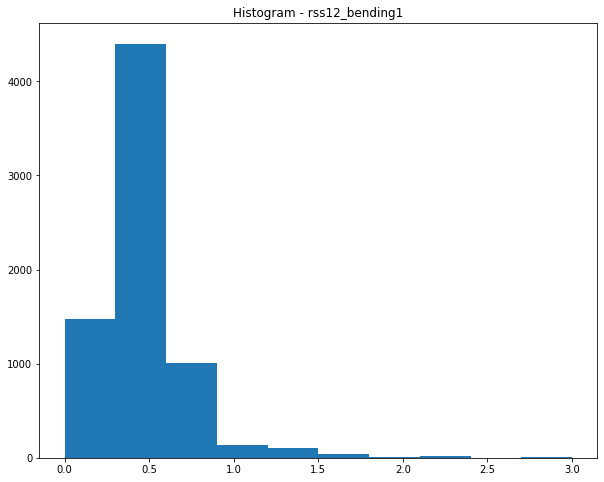

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.hist(var_activity['rss12_bending1'])
plt.title('Histogram - rss12_bending1')

Text(0.5, 1.0, 'Histogram - rss13_bending1')

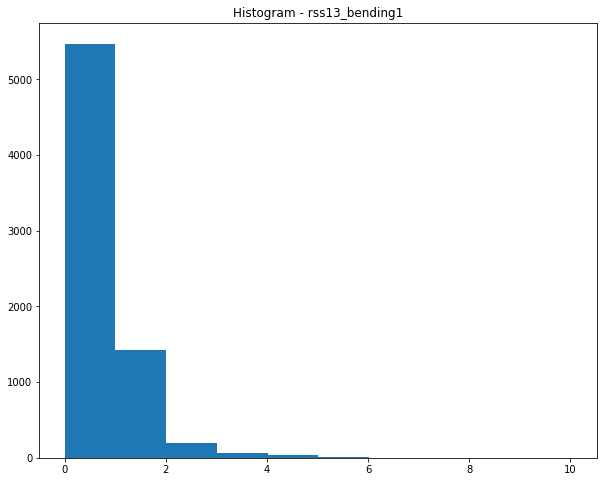

In [13]:
plt.figure(figsize=(10,8))
plt.hist(var_activity['rss13_bending1'])
plt.title('Histogram - rss13_bending1')

Text(0.5, 1.0, 'Histogram - rss13_cycling')

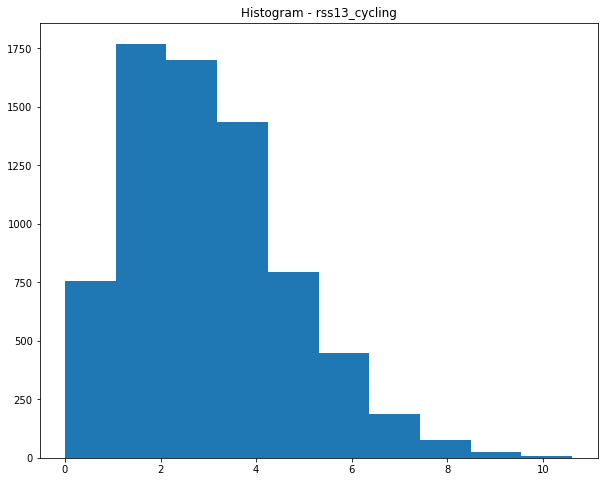

In [14]:
plt.figure(figsize=(10,8))
plt.hist(var_activity['rss13_cycling'])
plt.title('Histogram - rss13_cycling')

Text(0.5, 1.0, 'Histogram - rss23_cycling')

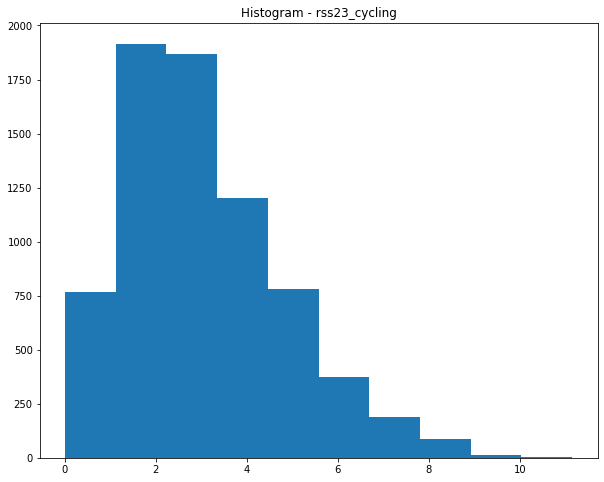

In [15]:
plt.figure(figsize=(10,8))
plt.hist(var_activity['rss23_cycling'])
plt.title('Histogram - rss23_cycling')

Text(0.5, 1.0, 'Histogram - rss12_sitting')

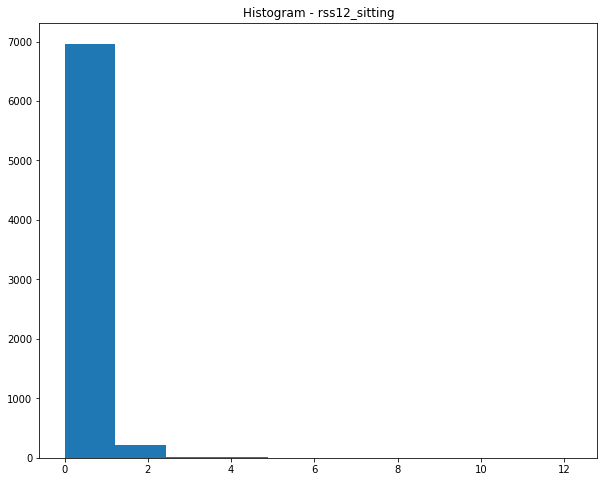

In [16]:
plt.figure(figsize=(10,8))
plt.hist(var_activity['rss12_sitting'])
plt.title('Histogram - rss12_sitting')

Text(0.5, 1.0, 'Histogram - rss23_sitting')

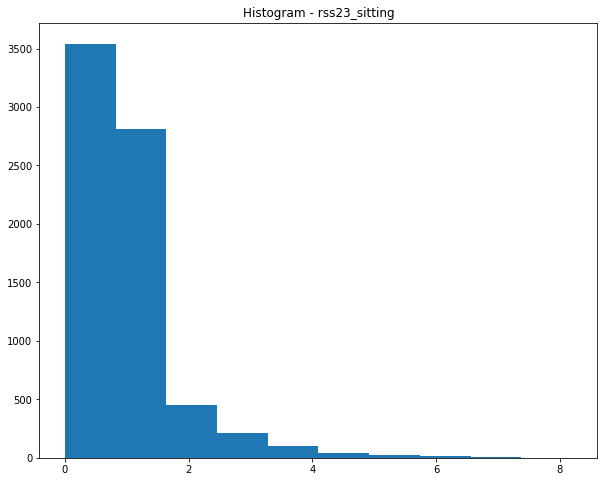

In [17]:
plt.figure(figsize=(10,8))
plt.hist(var_activity['rss23_sitting'])
plt.title('Histogram - rss23_sitting')

Next step in EDA - determine the normality and skewness of each column

[Text(0.5, 1.0, 'Heatmap - variance measure')]

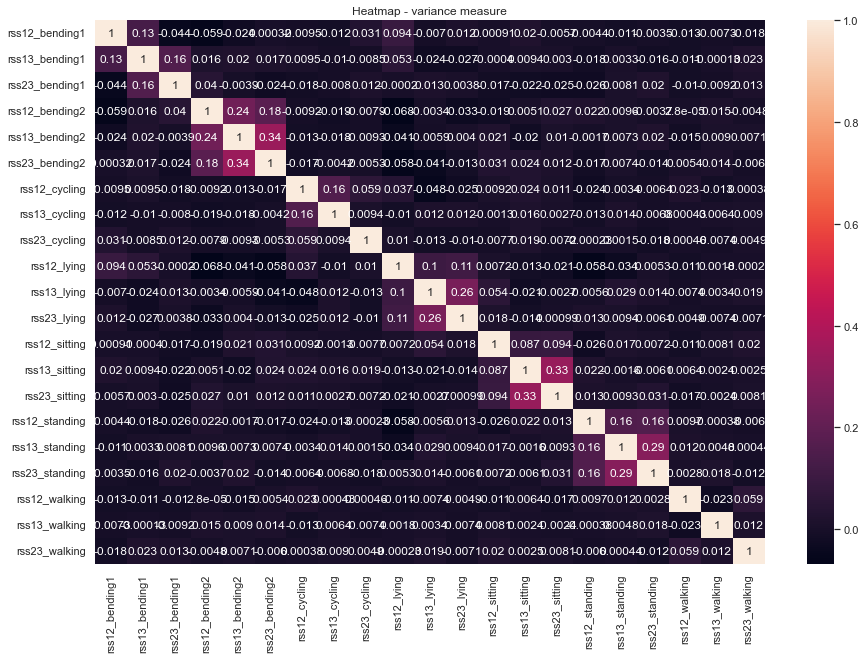

In [18]:
import seaborn as sns
sns.set(rc= {"figure.figsize": (15, 10)})
sns.heatmap(var_activity.iloc[:,1:22].corr(), annot = True).set(title='Heatmap - variance measure')

[Text(0.5, 1.0, 'Heatmap - mean measure')]

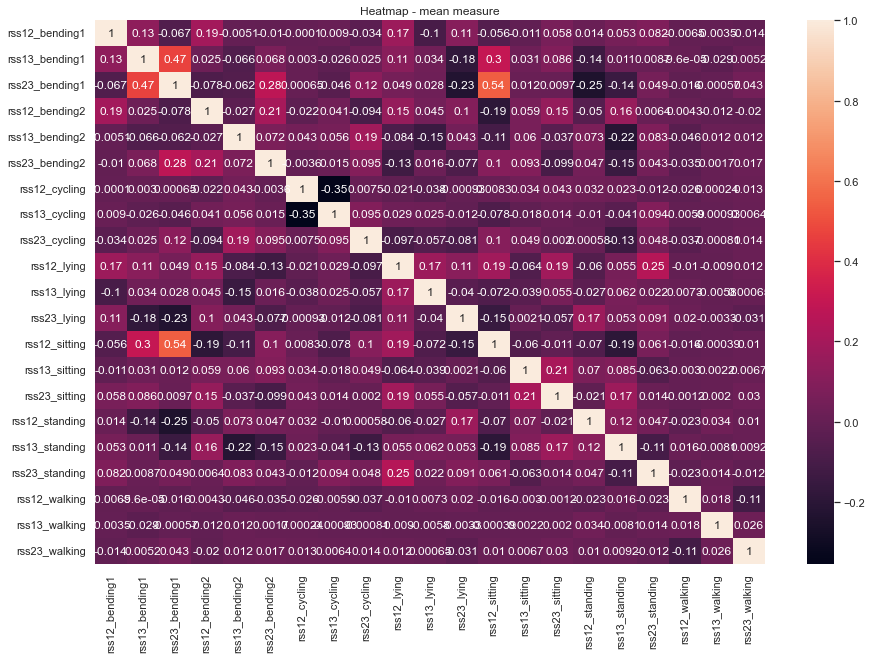

In [19]:
sns.set(rc= {"figure.figsize": (15, 10)})
sns.heatmap(mean_activity.iloc[:,1:22].corr(), annot = True).set(title='Heatmap - mean measure')

Detailed interpretations of the visualizations are written in the report document, and a structured view of the dataset patterns can be viewed in test_dash.py, which is in the same repository as this script.

### Statistical Methods and Models

In [20]:
mean_activity_df = mean_activity.iloc[:,1:] # exclude time variable
var_activity_df = var_activity.iloc[:,1:] # exclude time variable

### 1. PCA

In [21]:
# uc1 - dataset for use case #1
uc1 = mean_activity.loc[:, ~mean_activity.columns.isin(['time', 'subject_id','num_type'])]
# set X. There is no y for PCA in this data
X = uc1.astype('float32')
X

,rss12_bending1,rss13_bending1,rss23_bending1,rss12_bending2,rss13_bending2,rss23_bending2,rss12_cycling,rss13_cycling,rss23_cycling,rss12_lying,...,rss23_lying,rss12_sitting,rss13_sitting,rss23_sitting,rss12_standing,rss13_standing,rss23_standing,rss12_walking,rss13_walking,rss23_walking
0,39.250000,22.750000,33.750000,23.750000,24.000000,24.670000,32.00,17.50,22.50,29.00,...,8.50,42.000000,19.200001,15.50,46.50,11.50,20.33,35.00,16.50,14.00
1,39.250000,23.000000,33.000000,22.670000,24.000000,24.670000,40.50,14.00,21.75,29.00,...,8.50,42.000000,19.330000,11.00,46.50,12.00,20.25,28.50,17.50,12.25
2,39.250000,23.250000,33.000000,21.330000,24.000000,24.750000,40.50,11.33,18.25,29.00,...,8.00,42.000000,17.500000,12.50,46.50,12.00,20.50,35.50,15.75,17.75
3,39.500000,23.000000,33.000000,21.000000,24.000000,25.250000,34.50,20.67,19.00,28.50,...,8.75,42.000000,17.000000,13.33,46.50,12.75,19.50,29.75,16.25,20.75
4,39.500000,24.000000,33.000000,23.000000,23.750000,24.750000,34.50,21.25,18.25,29.00,...,9.00,42.000000,17.500000,12.00,46.50,13.25,18.75,27.00,16.75,24.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,42.582859,16.892857,28.142857,29.195000,11.986667,19.721666,38.00,18.25,20.00,29.25,...,10.50,41.000000,17.250000,11.00,45.25,12.25,13.75,34.50,9.00,12.67
7196,43.060001,18.714285,28.761429,28.833334,12.541667,19.583334,36.00,19.00,13.67,29.25,...,10.25,41.500000,18.000000,10.67,45.00,12.60,14.25,25.75,13.75,16.00
7197,43.439999,18.535715,29.225714,29.125000,12.251667,18.778334,37.00,17.75,22.50,29.50,...,9.67,41.330002,18.670000,11.00,45.00,12.00,14.50,31.50,10.25,16.25
7198,43.107143,18.879999,27.821428,29.341667,11.776667,19.375000,37.00,19.00,22.00,29.00,...,10.00,41.500000,18.500000,12.33,45.50,12.25,14.50,33.75,14.00,13.75


In [22]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance, function needs samples as columns
        cov = np.cov(X.T)

        # eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # store first n eigenvectors
        self.components = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        X = X - self.mean
        return np.dot(X, self.components.T)

In [23]:
# Project the data onto the 3 primary principal components
pca = PCA(3)
pca.fit(X)
X_projected = pca.transform(X)
X_projected

array([[-11.2186997 ,  -5.68151728,   1.94097633],
       [-12.3657626 ,  -6.08955737,  -0.05892045],
       [-11.98756375,  -6.10589879,  -0.51161109],
       ...,
       [-11.40513182,  -0.30469471,  -0.38315371],
       [-11.56935018,   0.77392821,   0.1682969 ],
       [-11.06598577,   1.79002023,  -0.25918301]])

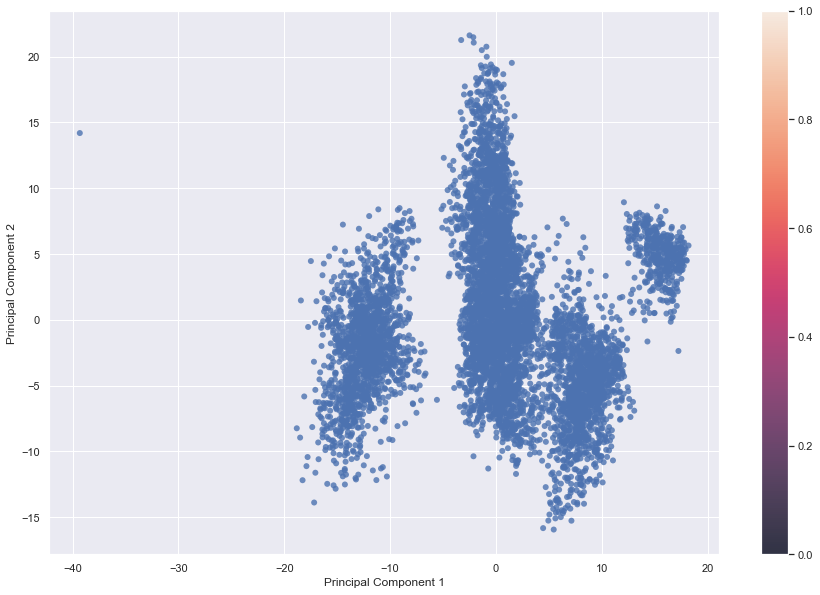

In [24]:
x1 = X_projected[:, 0]
x2 = X_projected[:, 1]
x3 = X_projected[:, 2]
import matplotlib.pyplot as plt
plt.scatter(x1, x2, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

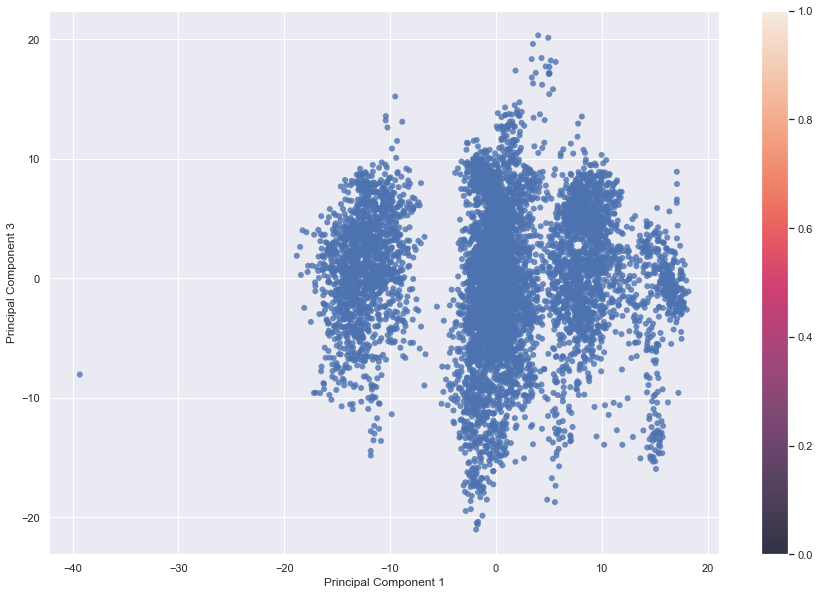

In [25]:
plt.scatter(x1, x3, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 3")
plt.colorbar()
plt.show()

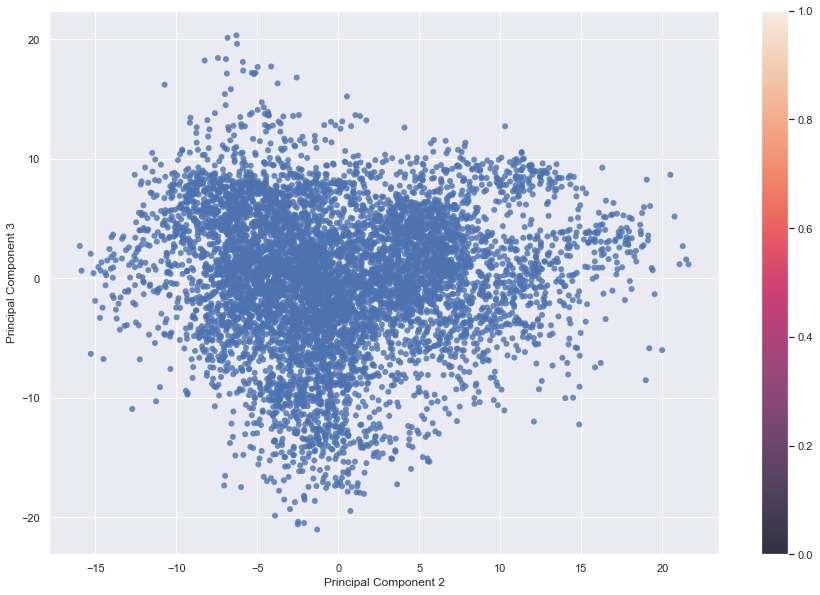

In [26]:
plt.scatter(x2, x3, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
plt.xlabel("Principal Component 2")
plt.ylabel("Principal Component 3")
plt.colorbar()
plt.show()

### 2. Statistical Models

#### Decision Tree:

In [27]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [28]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [29]:
def search_decision_tree_splits(min_samples_split, max_depth, X_train, y_train):
    classifier = DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=max_depth)
    classifier.fit(X_train, y_train.reshape(-1,1))
    y_pred = classifier.predict(X_test)
    
    cm_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    print('Decision Tree precision when min_samples_split =', min_samples_split, 'and max_depth =', max_depth, ':', len(cm_df[cm_df['y_test'] == cm_df['y_pred']]) / len(cm_df))

#### K-NN

In [30]:
from scipy.stats import mode
class KNN_Classifier() : 
    def __init__(self, k) :
        self.k = k
          
    def fit(self, X_train, y_train) :  
        self.X_train = X_train  
        self.y_train = y_train
      
    def predict(self, X_test) :
        self.X_test = X_test
          
        # prediction
        y_pred = np.zeros(self.X_test.shape[0])
        for i in range(self.X_test.shape[0]) :
            x = self.X_test[i] 
            neighbors = np.zeros(self.k)              
            neighbors = self.find_neighbors(x)           
            y_pred[i] = mode(neighbors)[0][0]    
              
        return y_pred
          
    def find_neighbors(self, x) :   
        # using the most commonly used distance metric, Euclidean
        euclidean_dist = np.zeros(self.X_test.shape[0])   
        for i in range(self.X_test.shape[0]) :
            d = np.sqrt(np.sum(np.square(x - self.X_train[i])))
            euclidean_dist[i] = d
            
        inds = euclidean_dist.argsort()
          
        Y_train_sorted = self.y_train[inds]
          
        return Y_train_sorted[:self.k]
  

In [31]:
def grid_search_knn(k_value, X_train, y_train):
    knn = KNN_Classifier(k = k_value)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    cm_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    print('KNN precision when k =', k_value, ':', len(cm_df[cm_df['y_test'] == cm_df['y_pred']]) / len(cm_df))


Binary Neural Network classifier:

In [32]:
from sklearn.metrics import mean_squared_error
class NeuralNet():
    '''
    A two layer neural network
    '''
        
    def __init__(self, layers=[15,8,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
                
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.random.randn(self.layers[2],)
    
    def relu(self,Z):
        return np.maximum(0,Z)

    def encode_class(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def eta(self, x):
        ETA = 0.0000000001
        return np.maximum(x, ETA)


    def sigmoid(self,Z):
        '''
        The sigmoid function takes in real numbers in any range and 
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1/(1+np.exp(-Z))

    def entropy_loss(self,y, yhat):
        nsample = len(y)
        yhat_inv = 1.0 - yhat
        y_inv = 1.0 - y
        yhat = self.eta(yhat) ## clips value to avoid NaNs in log
        yhat_inv = self.eta(yhat_inv) 
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
        return loss

    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
        dl_wrt_sig = yhat * (yhat_inv)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)
        #print(self.params['Z1'])
        dl_wrt_z1 = dl_wrt_A1 * self.encode_class(self.params['Z1'])
        #print(dl_wrt_z1)
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)

    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)     
        Z2 = A1.dot(self.params['W2']) + self.params['b2'] 
        pred = self.sigmoid(Z2)
        return np.round(pred) 

    def acc(self, y, yhat):
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()  
        

#### 2.1. Activity Classification

In [33]:
uc2 = np.transpose(mean_activity.loc[:, ~mean_activity.columns.isin(['time', 'subject_id','num_type'])])
uc2['activity_type'] = uc2.index
class_code_df = pd.DataFrame({'activity_type':uc2['activity_type'], 'class_code':range(len(uc2['activity_type']))})
class_code_df['class_code'] = np.where(class_code_df['activity_type'].isin(['rss12_bending1', 'rss13_bending1', 'rss23_bending1', 'rss12_bending2', 'rss13_bending2', 'rss23_bending2']), 1, 
        np.where(class_code_df['activity_type'].isin(['rss12_sitting', 'rss13_sitting', 'rss23_sitting', 'rss12_lying', 'rss13_lying', 'rss23_lying', 'rss12_standing', 'rss13_standing', 'rss23_standing']), 2, 
        np.where(class_code_df['activity_type'].isin(['rss12_cycling', 'rss13_cycling', 'rss23_cycling', 'rss12_walking', 'rss13_walking', 'rss23_walking']), 3, 'NA')))
class_code_df

,activity_type,class_code
rss12_bending1,rss12_bending1,1
rss13_bending1,rss13_bending1,1
rss23_bending1,rss23_bending1,1
rss12_bending2,rss12_bending2,1
rss13_bending2,rss13_bending2,1
rss23_bending2,rss23_bending2,1
rss12_cycling,rss12_cycling,3
rss13_cycling,rss13_cycling,3
rss23_cycling,rss23_cycling,3
rss12_lying,rss12_lying,2


In [34]:
uc2 = pd.merge(uc2, class_code_df, on = 'activity_type')
uc2 = uc2.loc[:, ~uc2.columns.isin(['activity_type'])]
class_code_df.reset_index(inplace = True, drop = True)
uc2['class_code'] = pd.to_numeric(uc2['class_code'])
uc2

,0,1,2,3,4,5,6,7,8,9,...,7191,7192,7193,7194,7195,7196,7197,7198,7199,class_code
0,39.250000,39.25,39.25,39.50,39.50,39.25,39.25,39.000000,39.50,39.50,...,41.881428,41.428570,41.737144,41.915714,42.582859,43.060001,43.439999,43.107143,43.535713,1
1,22.750000,23.00,23.25,23.00,24.00,24.00,24.00,23.750000,24.00,23.00,...,18.345715,17.381428,17.524286,17.234285,16.892857,18.714285,18.535715,18.879999,20.107143,1
2,33.750000,33.00,33.00,33.00,33.00,33.00,33.00,33.000000,33.00,33.00,...,27.309999,27.357143,27.618572,27.964285,28.142857,28.761429,29.225714,27.821428,27.000000,1
3,23.750000,22.67,21.33,21.00,23.00,24.33,23.75,21.750000,20.25,19.00,...,29.278334,29.153334,29.223333,29.166666,29.195000,28.833334,29.125000,29.341667,29.083332,1
4,24.000000,24.00,24.00,24.00,23.75,24.00,24.25,24.000000,24.50,24.25,...,15.625000,14.250000,14.140000,12.013333,11.986667,12.541667,12.251667,11.776667,10.458333,1
5,24.670000,24.67,24.75,25.25,24.75,24.25,24.75,24.750000,25.75,25.75,...,19.000000,19.913334,20.081667,19.475000,19.721666,19.583334,18.778334,19.375000,18.513332,1
6,32.000000,40.50,40.50,34.50,34.50,32.25,35.75,41.500000,39.75,30.75,...,36.000000,37.500000,38.750000,41.750000,38.000000,36.000000,37.000000,37.000000,38.750000,3
7,17.500000,14.00,11.33,20.67,21.25,21.50,13.00,13.000000,8.50,20.25,...,19.500000,17.500000,15.500000,12.250000,18.250000,19.000000,17.750000,19.000000,16.750000,3
8,22.500000,21.75,18.25,19.00,18.25,23.50,22.75,19.750000,20.00,16.33,...,22.000000,23.000000,21.750000,18.000000,20.000000,13.670000,22.500000,22.000000,21.000000,3
9,29.000000,29.00,29.00,28.50,29.00,29.00,29.00,29.000000,29.00,29.00,...,29.000000,29.500000,29.250000,29.250000,29.250000,29.250000,29.500000,29.000000,29.000000,2


In [35]:
uc2_temp = uc2.loc[:, uc2.columns != 'class_code']
uc2_codes = uc2['class_code']

uc2_rep = pd.DataFrame()
for i in range(-20, 20):
    uc2_rep = pd.concat([uc2_rep, uc2_temp+i])
    
uc2_rep['activity_type'] = list(uc2_codes) * 40
uc2_rep

,0,1,2,3,4,5,6,7,8,9,...,7191,7192,7193,7194,7195,7196,7197,7198,7199,activity_type
0,19.250000,19.25,19.25,19.50,19.50,19.25,19.25,19.000000,19.50,19.500000,...,21.881428,21.428570,21.737144,21.915714,22.582859,23.060001,23.439999,23.107143,23.535713,1
1,2.750000,3.00,3.25,3.00,4.00,4.00,4.00,3.750000,4.00,3.000000,...,-1.654285,-2.618572,-2.475714,-2.765715,-3.107143,-1.285715,-1.464285,-1.120001,0.107143,1
2,13.750000,13.00,13.00,13.00,13.00,13.00,13.00,13.000000,13.00,13.000000,...,7.309999,7.357143,7.618572,7.964285,8.142857,8.761429,9.225714,7.821428,7.000000,1
3,3.750000,2.67,1.33,1.00,3.00,4.33,3.75,1.750000,0.25,-1.000000,...,9.278334,9.153334,9.223333,9.166666,9.195000,8.833334,9.125000,9.341667,9.083332,1
4,4.000000,4.00,4.00,4.00,3.75,4.00,4.25,4.000000,4.50,4.250000,...,-4.375000,-5.750000,-5.860000,-7.986667,-8.013333,-7.458333,-7.748333,-8.223333,-9.541667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,30.500000,31.00,31.00,31.75,32.25,32.50,32.25,31.250000,31.00,31.000000,...,31.330000,31.250000,31.670000,31.500000,31.250000,31.600000,31.000000,31.250000,31.500000,2
17,39.330002,39.25,39.50,38.50,37.75,38.00,38.00,38.669998,38.50,38.330002,...,33.330002,33.669998,31.750000,31.750000,32.750000,33.250000,33.500000,33.500000,33.000000,2
18,54.000000,47.50,54.50,48.75,46.00,55.00,57.50,54.250000,54.75,55.000000,...,47.750000,56.500000,50.500000,55.250000,53.500000,44.750000,50.500000,52.750000,56.000000,3
19,35.500000,36.50,34.75,35.25,35.75,31.25,35.00,35.000000,30.00,34.000000,...,30.250000,34.750000,32.250000,36.000000,28.000000,32.750000,29.250000,33.000000,37.250000,3


In [36]:
# set x and y
X = uc2_rep.loc[:, uc2_rep.columns != 'activity_type'].astype('float32')
X = (X-X.min())/ (X.max() - X.min())
X = X.iloc[:,:].values
y = uc2_rep['activity_type'].values

# split into 80:20 training:testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

KNN:

In [37]:
for k in range(3,21):
    grid_search_knn(k, X_train, y_train)

KNN precision when k = 3 : 0.7619047619047619
KNN precision when k = 4 : 0.7440476190476191
KNN precision when k = 5 : 0.7023809523809523
KNN precision when k = 6 : 0.6726190476190477
KNN precision when k = 7 : 0.6369047619047619
KNN precision when k = 8 : 0.6369047619047619
KNN precision when k = 9 : 0.6428571428571429
KNN precision when k = 10 : 0.6071428571428571
KNN precision when k = 11 : 0.6130952380952381
KNN precision when k = 12 : 0.6071428571428571
KNN precision when k = 13 : 0.5833333333333334
KNN precision when k = 14 : 0.5952380952380952
KNN precision when k = 15 : 0.5595238095238095
KNN precision when k = 16 : 0.5654761904761905
KNN precision when k = 17 : 0.5773809523809523
KNN precision when k = 18 : 0.5476190476190477
KNN precision when k = 19 : 0.5714285714285714
KNN precision when k = 20 : 0.5297619047619048


Implementations

In [38]:
knn_uc1 = KNN_Classifier(k = 3)
knn_uc1.fit(X_train, y_train)
y_pred = knn_uc1.predict(X_test)

In [39]:
cm_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
cm = pd.crosstab(cm_df['y_test'], cm_df['y_pred'], rownames=['Actual'], colnames=['Predict'])
cm

Predict,1.0,2.0,3.0
Actual,,,
1,33,11,7
2,10,54,8
3,2,2,41


In [40]:
print('K-NN precision:', len(cm_df[cm_df['y_test'] == cm_df['y_pred']]) / len(cm_df))

K-NN precision: 0.7619047619047619


####  2.2. Time Series Classification

In [41]:
uc3 = mean_activity.loc[:, ~mean_activity.columns.isin(['num_type'])]
uc3['total_signal'] = round(uc3.loc[:, ~uc3.columns.isin(['time', 'subject_id'])].sum(axis=1))
df = uc3[['time', 'subject_id', 'total_signal']]
df

,time,subject_id,total_signal
0,0.0,1.0,507.0
1,250.0,1.0,498.0
2,500.0,1.0,501.0
3,750.0,1.0,503.0
4,1000.0,1.0,507.0
...,...,...,...
7195,118750.0,15.0,465.0
7196,119000.0,15.0,461.0
7197,119250.0,15.0,471.0
7198,119500.0,15.0,476.0


In [42]:
df = pd.pivot_table(df,index=['time'], columns='subject_id',values='total_signal').reset_index()
df

subject_id,time,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
0,0.0,507.0,496.0,489.0,522.0,460.0,519.0,445.0,489.0,518.0,488.0,506.0,493.0,491.0,498.0,472.0
1,250.0,498.0,515.0,499.0,517.0,467.0,514.0,466.0,509.0,516.0,506.0,499.0,503.0,481.0,503.0,458.0
2,500.0,501.0,511.0,484.0,517.0,465.0,518.0,484.0,500.0,524.0,488.0,513.0,488.0,487.0,497.0,457.0
3,750.0,503.0,499.0,487.0,523.0,466.0,519.0,461.0,498.0,499.0,495.0,493.0,495.0,497.0,496.0,465.0
4,1000.0,507.0,496.0,483.0,512.0,490.0,509.0,467.0,501.0,514.0,490.0,505.0,490.0,490.0,514.0,467.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,118750.0,514.0,466.0,518.0,462.0,506.0,465.0,479.0,512.0,492.0,481.0,501.0,482.0,493.0,501.0,465.0
476,119000.0,505.0,489.0,516.0,461.0,504.0,459.0,487.0,494.0,500.0,461.0,502.0,468.0,497.0,519.0,461.0
477,119250.0,510.0,485.0,498.0,464.0,522.0,446.0,473.0,495.0,501.0,467.0,504.0,489.0,504.0,512.0,471.0
478,119500.0,503.0,490.0,499.0,478.0,503.0,444.0,464.0,499.0,497.0,457.0,494.0,483.0,507.0,495.0,476.0


In [43]:
df['time_label'] = np.where(df['time'] <= df['time'].quantile(0.25), 0, 1)
df = df.drop('time', axis = 1)
df

subject_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,time_label
0,507.0,496.0,489.0,522.0,460.0,519.0,445.0,489.0,518.0,488.0,506.0,493.0,491.0,498.0,472.0,0
1,498.0,515.0,499.0,517.0,467.0,514.0,466.0,509.0,516.0,506.0,499.0,503.0,481.0,503.0,458.0,0
2,501.0,511.0,484.0,517.0,465.0,518.0,484.0,500.0,524.0,488.0,513.0,488.0,487.0,497.0,457.0,0
3,503.0,499.0,487.0,523.0,466.0,519.0,461.0,498.0,499.0,495.0,493.0,495.0,497.0,496.0,465.0,0
4,507.0,496.0,483.0,512.0,490.0,509.0,467.0,501.0,514.0,490.0,505.0,490.0,490.0,514.0,467.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,514.0,466.0,518.0,462.0,506.0,465.0,479.0,512.0,492.0,481.0,501.0,482.0,493.0,501.0,465.0,1
476,505.0,489.0,516.0,461.0,504.0,459.0,487.0,494.0,500.0,461.0,502.0,468.0,497.0,519.0,461.0,1
477,510.0,485.0,498.0,464.0,522.0,446.0,473.0,495.0,501.0,467.0,504.0,489.0,504.0,512.0,471.0,1
478,503.0,490.0,499.0,478.0,503.0,444.0,464.0,499.0,497.0,457.0,494.0,483.0,507.0,495.0,476.0,1


In [44]:
# set x and y
X = df.loc[:, df.columns != 'time_label'].astype('float32')
X = (X-X.min())/ (X.max() - X.min())
X = X.iloc[:,:].values
y = df['time_label'].values

# split into 80:20 training:testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

KNN:

In [45]:
for k in range(3,40):
    grid_search_knn(k, X_train, y_train)

KNN precision when k = 3 : 0.96875
KNN precision when k = 4 : 0.9895833333333334
KNN precision when k = 5 : 0.9895833333333334
KNN precision when k = 6 : 0.9791666666666666
KNN precision when k = 7 : 1.0
KNN precision when k = 8 : 0.9895833333333334
KNN precision when k = 9 : 1.0
KNN precision when k = 10 : 1.0
KNN precision when k = 11 : 1.0
KNN precision when k = 12 : 0.9895833333333334
KNN precision when k = 13 : 0.9895833333333334
KNN precision when k = 14 : 0.9895833333333334
KNN precision when k = 15 : 0.9895833333333334
KNN precision when k = 16 : 0.9895833333333334
KNN precision when k = 17 : 1.0
KNN precision when k = 18 : 1.0
KNN precision when k = 19 : 1.0
KNN precision when k = 20 : 0.9895833333333334
KNN precision when k = 21 : 1.0
KNN precision when k = 22 : 0.9895833333333334
KNN precision when k = 23 : 1.0
KNN precision when k = 24 : 0.9895833333333334
KNN precision when k = 25 : 0.9791666666666666
KNN precision when k = 26 : 0.9895833333333334
KNN precision when k = 27

Decision Tree:

In [46]:
for i in range(3,10):
    for j in range(3, 10):
        search_decision_tree_splits(i, j, X_train, y_train)

Decision Tree precision when min_samples_split = 3 and max_depth = 3 : 0.96875
Decision Tree precision when min_samples_split = 3 and max_depth = 4 : 0.9791666666666666
Decision Tree precision when min_samples_split = 3 and max_depth = 5 : 0.9791666666666666
Decision Tree precision when min_samples_split = 3 and max_depth = 6 : 0.9791666666666666
Decision Tree precision when min_samples_split = 3 and max_depth = 7 : 0.9791666666666666
Decision Tree precision when min_samples_split = 3 and max_depth = 8 : 0.9791666666666666
Decision Tree precision when min_samples_split = 3 and max_depth = 9 : 0.9791666666666666
Decision Tree precision when min_samples_split = 4 and max_depth = 3 : 0.9583333333333334
Decision Tree precision when min_samples_split = 4 and max_depth = 4 : 0.96875
Decision Tree precision when min_samples_split = 4 and max_depth = 5 : 0.96875
Decision Tree precision when min_samples_split = 4 and max_depth = 6 : 0.96875
Decision Tree precision when min_samples_split = 4 and

Implementations:

In [47]:
knn_uc2 = KNN_Classifier(k = 7)
knn_uc2.fit(X_train, y_train)
y_pred = knn_uc2.predict(X_test)

In [48]:
cm_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
cm = pd.crosstab(cm_df['y_test'], cm_df['y_pred'], rownames=['Actual'], colnames=['Predict'])
cm

Predict,0.0,1.0
Actual,,
0,20,0
1,0,76


Neural Network:

In [49]:
# reset x and y
X = df.loc[:, df.columns != 'time_label'].astype('float32')
#X = (X-X.min())/ (X.max() - X.min())
#X = X.iloc[:,:].values
y = df['time_label'].values.reshape(X.shape[0], 1)

# split into 80:20 training:testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


#standardize the dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [50]:
for i in range(5, 21):
    nn = NeuralNet(layers = [15, i, 1])
    nn.fit(X_train, y_train) #train the model
    
    train_pred = nn.predict(X_train)
    test_pred = nn.predict(X_test)
    
    print("Hidden nodes =", i)
    print("Train accuracy is {}".format(nn.acc(y_train, train_pred)))
    print("Test accuracy is {}".format(nn.acc(y_test, test_pred)))

Hidden nodes = 5
Train accuracy is 93
Test accuracy is 95
Hidden nodes = 6
Train accuracy is 96
Test accuracy is 96
Hidden nodes = 7
Train accuracy is 96
Test accuracy is 97
Hidden nodes = 8
Train accuracy is 97
Test accuracy is 98
Hidden nodes = 9
Train accuracy is 98
Test accuracy is 100
Hidden nodes = 10
Train accuracy is 97
Test accuracy is 96
Hidden nodes = 11
Train accuracy is 96
Test accuracy is 98
Hidden nodes = 12
Train accuracy is 97
Test accuracy is 97
Hidden nodes = 13
Train accuracy is 97
Test accuracy is 97
Hidden nodes = 14
Train accuracy is 97
Test accuracy is 97
Hidden nodes = 15
Train accuracy is 98
Test accuracy is 100
Hidden nodes = 16
Train accuracy is 98
Test accuracy is 96
Hidden nodes = 17
Train accuracy is 97
Test accuracy is 97
Hidden nodes = 18
Train accuracy is 97
Test accuracy is 97
Hidden nodes = 19
Train accuracy is 98
Test accuracy is 97
Hidden nodes = 20
Train accuracy is 98
Test accuracy is 98


Implementation

In [51]:
nn_relu = NeuralNet(layers = [15, 9, 1]) # create the NN model
nn_relu.fit(X_train, y_train) #train the model

train_pred = nn_relu.predict(X_train)
test_pred = nn_relu.predict(X_test)

print("Train accuracy is {}".format(nn_relu.acc(y_train, train_pred)))
print("Test accuracy is {}".format(nn_relu.acc(y_test, test_pred)))

Train accuracy is 98
Test accuracy is 100


### Model Selection:
#### Activity recognition, mean dataframe:

In [52]:
# set x and y
X = uc2_rep.loc[:, uc2_rep.columns != 'activity_type'].astype('float32')
X = (X-X.min())/ (X.max() - X.min())
X = X.iloc[:,:].values
y = uc2_rep['activity_type'].values

In [53]:
knn_uc1 = KNN_Classifier(k = 3)
knn_uc1.fit(X, y)
y_pred = knn_uc1.predict(X)

In [54]:
cm_df = pd.DataFrame({'y_test': y, 'y_pred': y_pred})
print('K-NN precision:', len(cm_df[cm_df['y_test'] == cm_df['y_pred']]) / len(cm_df))

K-NN precision: 1.0


In [55]:
# confusion matrix
cm = pd.crosstab(cm_df['y_test'], cm_df['y_pred'], rownames=['Actual'], colnames=['Predict'])
cm

Predict,1.0,2.0,3.0
Actual,,,
1,240,0,0
2,0,360,0
3,0,0,240


#### Activity Recognition, variance dataframe:

In [56]:
uc2_var = np.transpose(var_activity.loc[:, ~mean_activity.columns.isin(['time', 'subject_id','num_type'])])
uc2_var['activity_type'] = uc2_var.index
class_code_df = pd.DataFrame({'activity_type':uc2_var['activity_type'], 'class_code':range(len(uc2_var['activity_type']))})
class_code_df['class_code'] = np.where(class_code_df['activity_type'].isin(['rss12_bending1', 'rss13_bending1', 'rss23_bending1', 'rss12_bending2', 'rss13_bending2', 'rss23_bending2']), 1, 
        np.where(class_code_df['activity_type'].isin(['rss12_sitting', 'rss13_sitting', 'rss23_sitting', 'rss12_lying', 'rss13_lying', 'rss23_lying', 'rss12_standing', 'rss13_standing', 'rss23_standing']), 2, 
        np.where(class_code_df['activity_type'].isin(['rss12_cycling', 'rss13_cycling', 'rss23_cycling', 'rss12_walking', 'rss13_walking', 'rss23_walking']), 3, 'NA')))

uc2_var = pd.merge(uc2_var, class_code_df, on = 'activity_type')
uc2_var = uc2_var.loc[:, ~uc2_var.columns.isin(['activity_type'])]
uc2_var['class_code'] = pd.to_numeric(uc2_var['class_code'])
class_code_df.reset_index(inplace = True, drop = True)
uc2_var

,0,1,2,3,4,5,6,7,8,9,...,7191,7192,7193,7194,7195,7196,7197,7198,7199,class_code
0,0.43,0.43,0.43,0.50,0.50,0.43,0.43,0.00,0.50,0.50,...,0.875714,0.698571,0.600000,0.598571,0.554286,0.501429,0.518571,0.611429,0.637143,1
1,0.43,0.00,0.43,0.71,0.00,0.00,0.00,0.43,0.00,0.00,...,1.382857,0.498571,0.698571,0.751429,1.520000,0.651429,1.095714,1.345714,0.675714,1
2,1.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.528571,0.621429,0.190000,0.421429,0.318571,0.480000,0.557143,0.658571,0.594286,1
3,0.43,0.94,0.47,0.00,0.71,0.47,1.09,0.43,0.43,0.71,...,0.530000,0.311667,0.156667,0.166667,0.280000,0.226667,0.071667,0.378333,0.475000,1
4,0.00,0.00,0.00,0.00,0.43,0.00,0.43,0.00,0.50,0.43,...,0.496667,0.940000,0.466667,0.710000,0.911667,1.178333,1.005000,0.886667,0.681667,1
5,0.47,0.94,0.83,1.09,0.83,0.43,0.83,0.43,0.83,1.30,...,0.930000,1.161667,1.146667,0.771667,0.720000,1.100000,1.181667,0.891667,1.168333,1
6,4.85,1.12,2.60,1.50,1.50,2.86,4.44,1.12,3.27,2.49,...,0.000000,1.500000,1.090000,1.790000,2.550000,0.000000,1.730000,3.740000,1.920000,3
7,3.35,2.24,4.50,2.87,3.27,2.29,3.94,2.94,7.50,4.92,...,1.500000,7.260000,5.550000,1.090000,2.170000,1.410000,0.430000,4.180000,3.490000,3
8,3.20,1.30,5.31,2.83,4.38,2.60,1.79,1.79,2.45,5.25,...,2.450000,1.410000,2.490000,4.640000,4.740000,1.250000,0.870000,1.410000,3.670000,3
9,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000,0.500000,0.430000,0.430000,0.430000,0.430000,0.500000,0.000000,0.000000,2


In [57]:
uc2_var_temp = uc2_var.loc[:, uc2_var.columns != 'class_code']
uc2_var_codes = uc2_var['class_code']

uc2_rep_var = pd.DataFrame()
for i in range(-20, 20):
    uc2_rep_var = pd.concat([uc2_rep_var, uc2_var_temp+i])
    
    
uc2_rep_var['activity_type'] = list(uc2_var_codes) * 40
uc2_rep_var

,0,1,2,3,4,5,6,7,8,9,...,7191,7192,7193,7194,7195,7196,7197,7198,7199,activity_type
0,-19.570000,-19.570000,-19.570000,-19.500000,-19.500000,-19.570000,-19.570000,-20.000000,-19.500000,-19.500000,...,-19.124287,-19.301428,-19.400000,-19.401428,-19.445715,-19.498571,-19.481428,-19.388571,-19.362858,1
1,-19.570000,-20.000000,-19.570000,-19.290001,-20.000000,-20.000000,-20.000000,-19.570000,-20.000000,-20.000000,...,-18.617144,-19.501429,-19.301428,-19.248571,-18.480000,-19.348572,-18.904285,-18.654285,-19.324286,1
2,-18.700001,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,...,-19.471428,-19.378571,-19.809999,-19.578571,-19.681429,-19.520000,-19.442858,-19.341429,-19.405714,1
3,-19.570000,-19.059999,-19.530001,-20.000000,-19.290001,-19.530001,-18.910000,-19.570000,-19.570000,-19.290001,...,-19.469999,-19.688334,-19.843334,-19.833334,-19.719999,-19.773333,-19.928333,-19.621666,-19.525000,1
4,-20.000000,-20.000000,-20.000000,-20.000000,-19.570000,-20.000000,-19.570000,-20.000000,-19.500000,-19.570000,...,-19.503334,-19.059999,-19.533333,-19.290001,-19.088333,-18.821667,-18.995001,-19.113333,-19.318333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,19.500000,19.000000,19.000000,19.430000,19.430000,19.500000,19.430000,19.430000,19.000000,19.000000,...,19.469999,19.430000,19.469999,19.500000,19.430000,19.799999,19.000000,19.430000,19.870001,2
17,19.940001,19.430000,19.500000,19.500000,19.430000,20.000000,19.709999,19.469999,19.500000,20.250000,...,19.469999,19.469999,19.430000,20.299999,19.830000,19.830000,19.500000,19.500000,19.709999,2
18,22.670000,22.350000,21.869999,31.189999,21.119999,24.610001,23.330000,21.490000,26.049999,26.040001,...,26.889999,22.200001,21.600000,24.630001,25.180000,25.020000,22.350000,21.770000,20.410000,3
19,22.770000,22.770000,21.860001,21.170000,19.830000,21.280001,24.700001,20.410000,23.420000,21.119999,...,22.770000,24.540001,24.930000,21.160000,22.559999,21.049999,24.119999,22.240000,22.700001,3


In [58]:
# set x and y
X = uc2_rep_var.loc[:, uc2_rep_var.columns != 'activity_type'].astype('float32')
X = (X-X.min())/ (X.max() - X.min())
X = X.iloc[:,:].values
y = uc2_rep_var['activity_type'].values

In [59]:
knn_uc1 = KNN_Classifier(k = 3)
knn_uc1.fit(X, y)
y_pred = knn_uc1.predict(X)

In [60]:
cm_df = pd.DataFrame({'y_test': y, 'y_pred': y_pred})
print('K-NN precision:', len(cm_df[cm_df['y_test'] == cm_df['y_pred']]) / len(cm_df))

K-NN precision: 0.8559523809523809


In [61]:
# confusion matrix
cm = pd.crosstab(cm_df['y_test'], cm_df['y_pred'], rownames=['Actual'], colnames=['Predict'])
cm

Predict,1.0,2.0,3.0
Actual,,,
1,200,40,0
2,81,279,0
3,0,0,240


#### Time-series clustering, mean data

In [62]:
# set x and y
X = df.loc[:, df.columns != 'time_label'].astype('float32')
X = (X-X.min())/ (X.max() - X.min())
X = X.iloc[:,:].values
y = df['time_label'].values.reshape(X.shape[0], 1)

In [63]:
nn_relu = NeuralNet(layers = [15, 9, 1])
nn_relu.fit(X, y) #train the model

y_pred = nn_relu.predict(X)

print("Prediction accuracy is {}".format(nn_relu.acc(y, y_pred)))

Prediction accuracy is 97


In [64]:
cm_df = pd.DataFrame({'y_test': y.flatten(), 'y_pred': y_pred.flatten()})

# confusion matrix
cm = pd.crosstab(cm_df['y_test'], cm_df['y_pred'], rownames=['Actual'], colnames=['Predict'])
cm

Predict,0.0,1.0
Actual,,
0,118,2
1,8,352


#### Time-series clustering, variance data

In [65]:
uc3_var = var_activity.loc[:, ~var_activity.columns.isin(['num_type'])]
uc3_var['total_signal'] = round(uc3_var.loc[:, ~uc3_var.columns.isin(['time', 'subject_id'])].sum(axis=1))
df = uc3_var[['time', 'subject_id', 'total_signal']]
df = pd.pivot_table(df,index=['time'], columns='subject_id',values='total_signal').reset_index()

df['time_label'] = np.where(df['time'] <= df['time'].quantile(0.50), 0, 1)
df = df.drop('time', axis = 1)
df

subject_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,time_label
0,30.0,28.0,33.0,24.0,21.0,36.0,28.0,42.0,26.0,25.0,26.0,34.0,30.0,27.0,43.0,0
1,22.0,27.0,47.0,23.0,24.0,38.0,27.0,21.0,31.0,24.0,35.0,31.0,27.0,27.0,24.0,0
2,29.0,24.0,36.0,29.0,26.0,29.0,29.0,34.0,32.0,32.0,28.0,39.0,33.0,38.0,30.0,0
3,32.0,29.0,28.0,31.0,36.0,25.0,34.0,25.0,36.0,28.0,31.0,28.0,29.0,32.0,27.0,0
4,20.0,28.0,30.0,32.0,27.0,29.0,30.0,25.0,33.0,37.0,31.0,45.0,32.0,29.0,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,25.0,27.0,29.0,36.0,43.0,26.0,21.0,26.0,30.0,31.0,22.0,35.0,31.0,31.0,33.0,1
476,17.0,30.0,16.0,37.0,27.0,23.0,26.0,27.0,20.0,40.0,41.0,33.0,34.0,26.0,21.0,1
477,18.0,36.0,38.0,32.0,28.0,40.0,29.0,25.0,29.0,35.0,36.0,31.0,28.0,36.0,24.0,1
478,33.0,36.0,29.0,27.0,26.0,24.0,29.0,34.0,31.0,28.0,37.0,37.0,31.0,39.0,25.0,1


In [66]:
# set x and y
X = df.loc[:, df.columns != 'time_label'].astype('float32')
X = (X-X.min())/ (X.max() - X.min())
X = X.iloc[:,:].values
y = df['time_label'].values.reshape(X.shape[0], 1)

In [67]:
nn_relu = NeuralNet(layers = [15, 9, 1])
nn_relu.fit(X, y) #train the model

y_pred = nn_relu.predict(X)

print("Prediction accuracy is {}".format(nn_relu.acc(y, y_pred)))

Prediction accuracy is 53


In [68]:
cm_df = pd.DataFrame({'y_test': y.flatten(), 'y_pred': y_pred.flatten()})

# confusion matrix
cm = pd.crosstab(cm_df['y_test'], cm_df['y_pred'], rownames=['Actual'], colnames=['Predict'])
cm

Predict,0.0,1.0
Actual,,
0,127,113
1,109,131
